# Week 4 Homework

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import roc_curve, auc, roc_auc_score 
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

### Dataset:

In [3]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [4]:
PATH = "./AER_credit_card_data.csv"
data = pd.read_csv(PATH)

In [5]:
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


### Preparation:

In [6]:
data['card']

0       yes
1       yes
2       yes
3       yes
4       yes
       ... 
1314    yes
1315     no
1316    yes
1317    yes
1318    yes
Name: card, Length: 1319, dtype: object

In [7]:
data['card'] = data['card'].eq('yes').mul(1)

In [8]:
data['card']

0       1
1       1
2       1
3       1
4       1
       ..
1314    1
1315    0
1316    1
1317    1
1318    1
Name: card, Length: 1319, dtype: int64

In [9]:
df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

### Question 1:

In [12]:
numerical = ['reports', 'age',	'income', 'share', 'expenditure', 'dependents',	'months', 'majorcards',	'active']

print("auc scores")
print("----------")
for col in df_train[numerical]:
    auc_score = roc_auc_score(y_train, df_train[col])

    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[col])
    
    print(f"{col}: {auc_score}")

auc scores
----------
reports: 0.7166629860689376
age: 0.5240020979407055
income: 0.5908049467233478
share: 0.989183643423692
expenditure: 0.991042345276873
dependents: 0.5327757227773791
months: 0.5294217780967629
majorcards: 0.5343859842838476
active: 0.6043173411362006


#### Ans: **share** with an AUC of 0.9892

### Training the model

In [13]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
numerical = ['reports', 'age',	'income', 'share', 'expenditure', 'dependents',	'months', 'majorcards',	'active']
categorical = ['owner', 'selfemp']

dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

### Question 2:

In [14]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [15]:
auc_score = roc_auc_score(y_val, y_pred)
round(auc_score, 3)

0.995

Ans: **0.995**

### Question 3:

In [16]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [17]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

In [18]:
print(df_scores)

     threshold   tp  fp  fn  tn    recall  precision
0         0.00  211  53   0   0  1.000000   0.799242
1         0.01  211  34   0  19  1.000000   0.861224
2         0.02  211  31   0  22  1.000000   0.871901
3         0.03  211  24   0  29  1.000000   0.897872
4         0.04  211  22   0  31  1.000000   0.905579
..         ...  ...  ..  ..  ..       ...        ...
96        0.96  204   0   7  53  0.966825   1.000000
97        0.97  203   0   8  53  0.962085   1.000000
98        0.98  203   0   8  53  0.962085   1.000000
99        0.99  202   0   9  53  0.957346   1.000000
100       1.00  179   0  32  53  0.848341   1.000000

[101 rows x 7 columns]


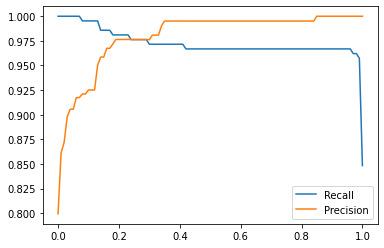

In [19]:
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.legend()

Ans: Choosing closest at **0.3**

### Question 4

In [20]:
df_scores['f1'] = 2 * ((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))
df_scores.f1.sort_values(ascending=True)

0      0.888421
100    0.917949
1      0.925439
2      0.931567
3      0.946188
         ...   
38     0.983213
40     0.983213
35     0.983213
41     0.983213
39     0.983213
Name: f1, Length: 101, dtype: float64

This is around 0.4

Ans: Choosing from best of given values, **0.4**

### Question 5:

In [24]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [25]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, 1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [27]:
np.std(scores)

0.0027434713804377724

Ans: rounds to **0.003**

### Question 6

In [29]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, 1.0)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.996 +- 0.003
C=0.1 0.996 +- 0.003
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


Ans: All values equal, going with lowest C value: **0.01**